In [117]:
%matplotlib widget
from pathlib import Path

import numpy as np
import scipy.signal as sps

from spectrometer import FID1D, plot, process

In [118]:
# Load raw *.fid data
file = Path("../data/20230822-081516-Water-1H-single_90_degree_pulse,length=9us,delay=30us,record_length=10000,sample_rate=320000,probe=andrew.fid")
fid = FID1D.from_file(file)

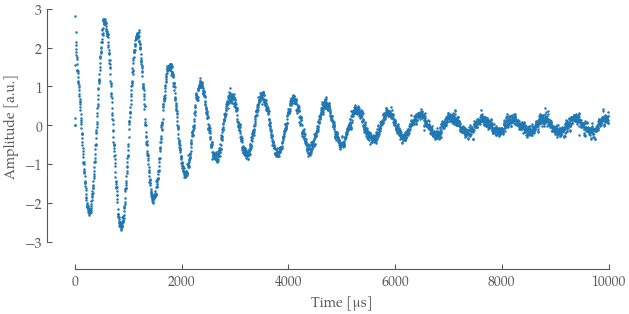

In [119]:
# Plot raw data
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    # fid.us_scale[:-1999],
    # np.convolve(fid.data.real, np.ones(2000), 'valid') / 2000,
    fid.us_scale,
    fid.data.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Time [μs]")

plot.format_axes(axes)

fig.savefig("fid_raw.pdf")

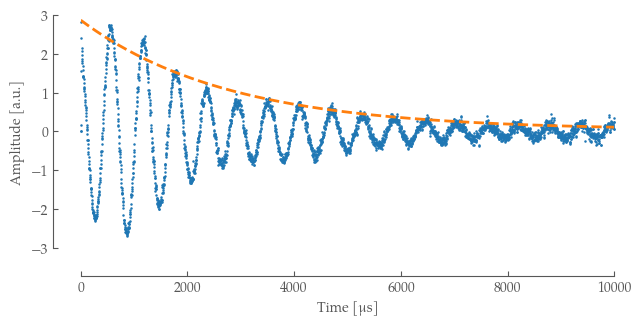

In [120]:
# Try fitting the envelope
try:
    envelope = np.abs(sps.hilbert(fid.data.real))
    fit_lorentz = process.fit_exp_decay(fid.us_scale, envelope)
    hz_scale_fine = np.linspace(fid.us_scale[0], fid.us_scale[-1], len(fid.us_scale) * 10)
    axes.plot(
        hz_scale_fine,
        fit_lorentz["function"](hz_scale_fine),
        linestyle="--",
        linewidth=2,
    )
except RuntimeError:
    pass

# Try fitting the absolute directly
try:
    fit_abs = process.fit_exp_decay(fid.us_scale, np.abs(fid.data))
    axes.plot(
        hz_scale_fine,
        fit_abs["function"](hz_scale_fine),
        linestyle=":",
        linewidth=2,
    )
except RuntimeError:
    pass

fig.savefig("fid_fit.pdf")
fig

Phase Shift: 32.21759375000004


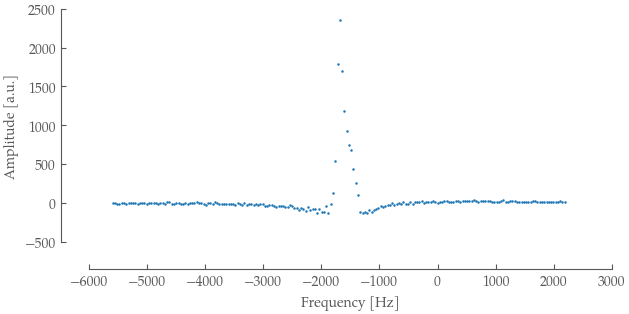

In [121]:
# Fourier Transform
hz_scale, fft_vals,p0 = fid.simple_fft()
# hz_scale, fft_vals = fid.simple_fft(phase_shift_kwargs={"p0": -100})
peak = np.argmax(np.abs(fft_vals))
peak_hz_scale = hz_scale[peak-100:peak+100]
peak_fft_vals = fft_vals[peak-100:peak+100]
print(f"Phase Shift: {p0}")

# Plot Fourier Transform
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    peak_hz_scale,
    peak_fft_vals.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Frequency [Hz]")

plot.format_axes(axes)

fig.savefig("fft_raw.pdf")

Amplitude: 2374.517987115117
Gamma: 62.13801721962174 Hz
Full Width at Half Maximum: 124.27603443924347 Hz
T2* is thus: 2.561313511652218 ms
Position: -1669.4608880312333 Hz


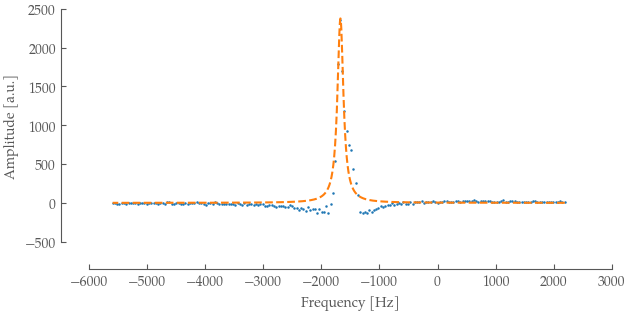

In [122]:
# Try to plot simple least squares fit for a lorentzian peak
fit_lorentz = process.fit_lorentz(peak_hz_scale, peak_fft_vals.real)
hz_scale_fine = np.linspace(peak_hz_scale[0], peak_hz_scale[-1], len(fid.us_scale) * 10)

# Plot Raw
cm = 1 / 2.54
fig, axes = plot.subplots(
    figsize=(16.0 * cm, 8.0 * cm),  # Wide Layout: ~16cm, Margin Layout: 10.7cm
)
axes.plot(
    peak_hz_scale,
    peak_fft_vals.real,
    linestyle="",
    marker="o",
    markersize=0.8,
)
axes.set_ylabel("Amplitude [a.u.]")
axes.set_xlabel("Frequency [Hz]")

plot.format_axes(axes)

# Plot fit
axes.plot(
    hz_scale_fine,
    fit_lorentz["function"](hz_scale_fine),
    linestyle="--",
)
print(f"Amplitude: {fit_lorentz['amplitude']}")
print(f"Gamma: {fit_lorentz['gamma']} Hz")
print(f"Full Width at Half Maximum: {fit_lorentz['gamma'] * 2} Hz")
print(f"T2* is thus: {1000/(np.pi * fit_lorentz['gamma']*2)} ms")
print(f"Position: {fit_lorentz['position']} Hz")


fig.savefig("fft_fit.pdf")